# Simple Titanic Survivors Logistic Regression

**Matthew Rogers**
**7/5/2021**

The sinking of the Titanic in 1912 remains one of the most deadly and infamous maritime disasters in history. of the 2224 passengers, 1502 were killed after the ship struck an iceberg in the atlantic ocean. Using a dataset from kaggle found [here](https://www.kaggle.com/c/titanic/overview), we can create a logistic regression model to predict whether different passengers lived or died in the disaster. 

### Basic Data Exploration

The data comes already split into a training and testing set. Since we don't want to even look at the testing set, we can load only the training set first and start looking at it

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
train.shape

(891, 12)

In [3]:
train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

The 12 variables are described as such

|Var. Name |Description |Key |
| --- | --- | --- |
| Survival | passenger survived y/n | 0 = no, 1 = yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | passenger sex | |
| age | age in years | |
| sibsp | number of siblings/spouses aboard | |
| parch | number of parents/children aboard | |
| ticket | ticket number | |
| fare | how much was paid for the ticket | |
| cabin | cabin number | |
| embarked | where the passenger embarked | C = Cherbourg, Q = Queenstown, S = Southhampton |

Now lets look for any NA values in the dataset

In [4]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age, Cabin, and Embarked are the only variables with missing values. Cabin might have too many missing values to work with it in our model, but we can look at age to see if imputing or removing the values could be helpful.

In [5]:
print("% missing in Age: ", round(train["Age"].isna().sum()/train.shape[0], 3))
print("% missing in Cabin: ", round(train["Cabin"].isna().sum()/train.shape[0], 3))
print("% missing in Embarked: ", round(train["Embarked"].isna().sum()/train.shape[0], 3))

% missing in Age:  0.199
% missing in Cabin:  0.771
% missing in Embarked:  0.002


Yeah, 77% of the Cabin is missing, we should probably drop it. We might be able to work with Age, and since so little of Embarked is missing, we should be able to just drop the two offending rows. Lets take a look at the distribution of age to see where we should go.

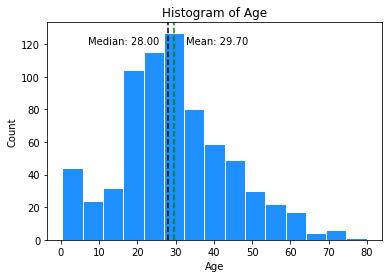

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
plt.hist(train["Age"], bins = 15, color = "dodgerblue", edgecolor = "white")
plt.title("Histogram of Age")
plt.xlabel("Age")
plt.ylabel("Count")

plt.axvline(train["Age"].mean(), linestyle = "dashed", color = "g")
plt.text(train["Age"].mean()*1.1, plt.ylim()[1] * 0.9, "Mean: {:.2f}".format(train["Age"].mean()))

plt.axvline(train["Age"].median(), linestyle = "dashed", color = "k")
plt.text(train["Age"].median()*0.25, plt.ylim()[1] * 0.9, "Median: {:.2f}".format(train["Age"].median()))
plt.show()

The median is only slightly lower than the mean, but since the data has some spikiness towards the left I'm leaning towards using the median to impute the 177 missing values in the age column. 

Since only 2 values are missing in the Embarked column, I believe it's safe to simply drop them. 

So to make the final transformations, we're going to:

 - Drop the "Cabin" column
 - Impute the median for missing "Age" values
 - Drop the 2 rows with missing "Embarked" values

In [7]:
train_polish = train.copy()

train_polish.drop("Cabin", axis = 1, inplace = True)
train_polish = train_polish.dropna(subset = ["Embarked"])
train_polish["Age"].fillna(train["Age"].median(skipna = True), inplace = True)

In [8]:
train_polish.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Now we've got the data cleaned up! One final thing we can do is change the "embarked" and "sex" columns to dummy variables (one hot encoding) to make the regression easier (or to just use them at all in a regression)

In [9]:
train_polish = pd.get_dummies(train_polish, columns = ["Sex", "Embarked"])

In [10]:
train_polish.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005028,-0.035330,0.031319,-0.057686,-0.001657,0.012703,-0.043136,0.043136,-0.001208,-0.033694,0.022269
Survived,-0.005028,1.000000,-0.335549,-0.069822,-0.034040,0.083151,0.255290,0.541585,-0.541585,0.169966,0.004536,-0.151777
Pclass,-0.035330,-0.335549,1.000000,-0.336512,0.081656,0.016824,-0.548193,-0.127741,0.127741,-0.245733,0.220558,0.076466
Age,0.031319,-0.069822,-0.336512,1.000000,-0.232543,-0.171485,0.093707,-0.086506,0.086506,0.032098,-0.030436,-0.008964
SibSp,-0.057686,-0.034040,0.081656,-0.232543,1.000000,0.414542,0.160887,0.116348,-0.116348,-0.060074,-0.026692,0.069438
Parch,-0.001657,0.083151,0.016824,-0.171485,0.414542,1.000000,0.217532,0.247508,-0.247508,-0.011588,-0.081585,0.061512
Fare,0.012703,0.255290,-0.548193,0.093707,0.160887,0.217532,1.000000,0.179958,-0.179958,0.270731,-0.116684,-0.163758
Sex_female,-0.043136,0.541585,-0.127741,-0.086506,0.116348,0.247508,0.179958,1.000000,-1.000000,0.084520,0.075217,-0.121405
Sex_male,0.043136,-0.541585,0.127741,0.086506,-0.116348,-0.247508,-0.179958,-1.000000,1.000000,-0.084520,-0.075217,0.121405
Embarked_C,-0.001208,0.169966,-0.245733,0.032098,-0.060074,-0.011588,0.270731,0.084520,-0.084520,1.000000,-0.148646,-0.782613


I think we can combine the SibSp and Parch into one column of just "relatives on board". I'll make a categorical and numeric variable to see if one is a stronger predictor than the other.  Let's do that and see if it adds a meaningful variable.

In [11]:
train_polish["relatives_cat"] = np.where(((train_polish["SibSp"] > 0) & (train_polish["SibSp"] > 0)), 1, 0)
train_polish["relatives_num"] = train_polish["SibSp"] + train_polish["Parch"]

In [12]:
train_polish.corr()["Survived"]

PassengerId     -0.005028
Survived         1.000000
Pclass          -0.335549
Age             -0.069822
SibSp           -0.034040
Parch            0.083151
Fare             0.255290
Sex_female       0.541585
Sex_male        -0.541585
Embarked_C       0.169966
Embarked_Q       0.004536
Embarked_S      -0.151777
relatives_cat    0.118087
relatives_num    0.018277
Name: Survived, dtype: float64

The relatives categorical predictor does a much better job predicting a passengers outcome than the numeric value, so I'll keep that and drop the other two variables representing the number of relatives on board.

In addition I'll be dropping the Name, Ticket number, and PassengerId variables as previously mentioned.

In [13]:
cols = ["Parch", "SibSp", "Name", "PassengerId", "Ticket", "relatives_num"]
train_polish = train_polish.drop(cols, axis = 1)

In [14]:
train_polish.corr()["Survived"]

Survived         1.000000
Pclass          -0.335549
Age             -0.069822
Fare             0.255290
Sex_female       0.541585
Sex_male        -0.541585
Embarked_C       0.169966
Embarked_Q       0.004536
Embarked_S      -0.151777
relatives_cat    0.118087
Name: Survived, dtype: float64

This looks pretty good! We can scale our dataset to give the model a little bit of an easier time working. However we should split the data into our training/testing sets first, as both sets should more or less represent fresh data.

In [15]:
from sklearn.model_selection import train_test_split

# drop the survived column 
survived = train_polish["Survived"]
preds = train_polish.drop("Survived", axis = 1)

xtrain, xtest, ytrain, ytest = train_test_split(preds, survived, test_size = 0.2, random_state = 123)

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

With our data scaled, we're ready to train the initial model!

In [17]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression()
mod.fit(xtrain, ytrain)

LogisticRegression()

Now lets see how the model did by running it against the testing dataset.

In [18]:
mod.score(xtest, ytest)

0.7752808988764045

The first model has a mean accuracy score of around 77%, which is a pretty solid first attempt! I'm only trying to do a basic regression here, but further options would include removing the age category, as it has a low correlation with survived, or creating some new factors to evaluate like a status variable created from the name variable. 

Before wrapping up we should create our predictions from the testing data given by the kaggle source.

In [19]:
test = pd.read_csv("test.csv")
passengerids = test["PassengerId"]
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [20]:
test["relatives_cat"] = np.where(((test["SibSp"] > 0) & (test["SibSp"] > 0)), 1, 0)
test = pd.get_dummies(test, columns = ["Sex", "Embarked"])
cols = ["Parch", "SibSp", "Name", "PassengerId", "Ticket", "Cabin"]
test = test.drop(cols, axis = 1)

In [21]:
test["Age"].fillna(test["Age"].median(skipna = True), inplace = True)
test["Fare"].fillna(test["Fare"].median(skipna = True), inplace = True)

In [22]:
test = scaler.fit_transform(test)

In [23]:
predictions = mod.predict(test)

In [24]:
dat = {"Passenger Ids": passengerids, "survived (predicted)": predictions}
final_preds = pd.DataFrame(dat, columns = ["Passenger Ids", "survived (predicted)"])
final_preds

,Passenger Ids,survived (predicted)
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0
